In [1]:

# Install required packages
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install xgboost --break-system-package

Note: you may need to restart the kernel to use updated packages.


Loaded data with shape: (1084731, 22)
Index(['FlightDate', 'Reporting_Airline', 'OriginAirportSeqID', 'OriginState',
       'DepDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'SeqID', 'Description', 'Latitude', 'Longitude',
       'date', 'weather_code', 'temperature_2m_max', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'],
      dtype='object')


/Users/akshatsharma/CS506/CS506-Final-Project/506env/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest - MAE: 5.26, RMSE: 11.33
XGBoost - MAE: 4.62, RMSE: 12.16


/Users/akshatsharma/CS506/CS506-Final-Project/506env/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


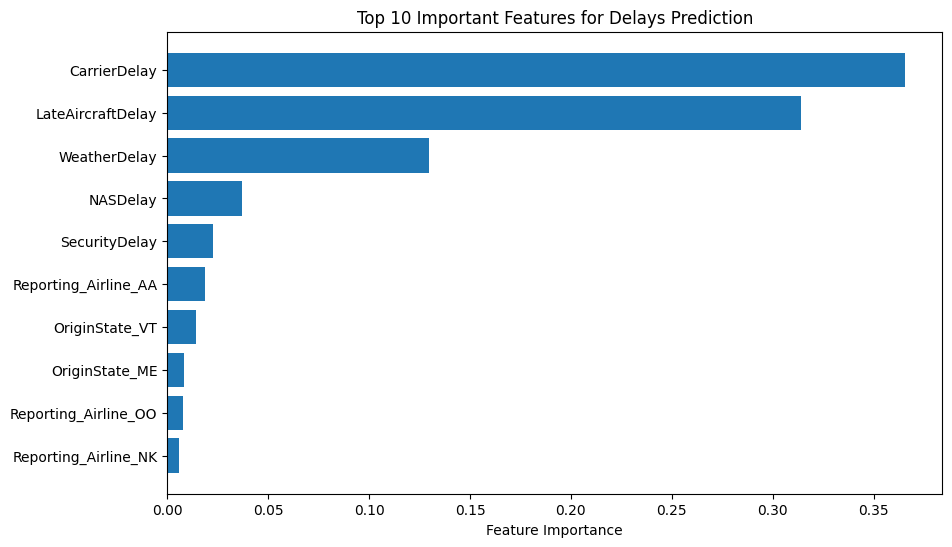

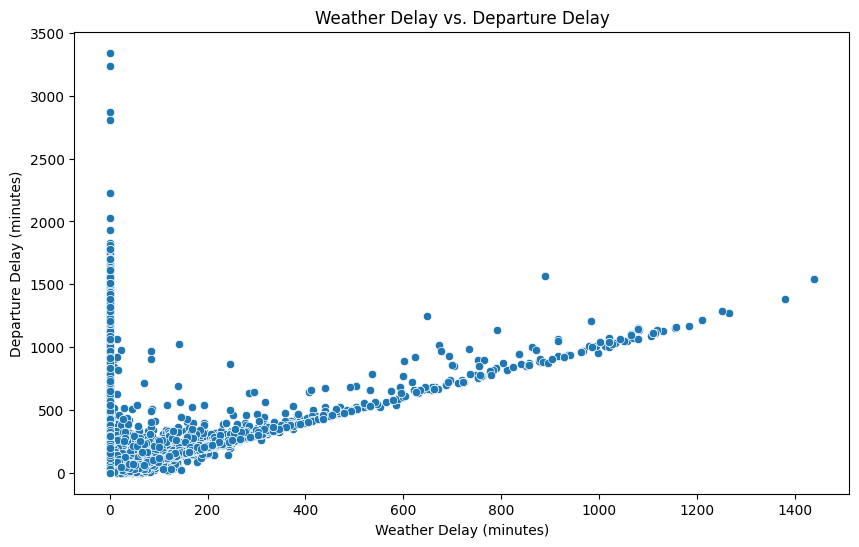

In [5]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load Data
# Load all processed monthly CSV files
all_files = glob.glob("processed_data/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
print(f"Loaded data with shape: {df.shape}")
print(df.columns)

# Step 2: Preprocessing
# Fill missing delay columns with 0
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Convert FlightDate to datetime and extract date-based features
if 'FlightDate' in df.columns:
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['DayOfWeek'] = df['FlightDate'].dt.dayofweek
    df['Month'] = df['FlightDate'].dt.month
    df['DayOfYear'] = df['FlightDate'].dt.dayofyear

# Handle missing values for weather-related features
weather_columns = ['temperature_2m_max', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
for col in weather_columns:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

# Drop or Encode Non-Numeric Columns
non_numeric_columns = df.select_dtypes(include=['object']).columns
columns_to_drop = ['FlightDate', 'Description', 'Cancelled', 'Diverted', 'CancellationCode']
columns_to_drop += [col for col in non_numeric_columns if col not in ['Reporting_Airline', 'OriginState']]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# One-hot encode categorical columns
categorical_columns = ['Reporting_Airline', 'OriginState']
for col in categorical_columns:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

# Step 3: Define the Target and Features
target_column = 'DepDelayMinutes'
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset")

X = df.drop(columns=[target_column])
y = df[target_column]

# Remove rows with NaN in the target variable
mask = y.notna()
X = X[mask]
y = y[mask]

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Training
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")

# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")

# Step 6: Feature Importance for XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Important Features for Delays Prediction")
    plt.show()

# Step 7: Visualization
if 'WeatherDelay' in df.columns and target_column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['WeatherDelay'], y=df[target_column])
    plt.xlabel('Weather Delay (minutes)')
    plt.ylabel('Departure Delay (minutes)')
    plt.title('Weather Delay vs. Departure Delay')
    plt.show()
else:
    print("Unable to create scatter plot: Required columns not found in the dataset")

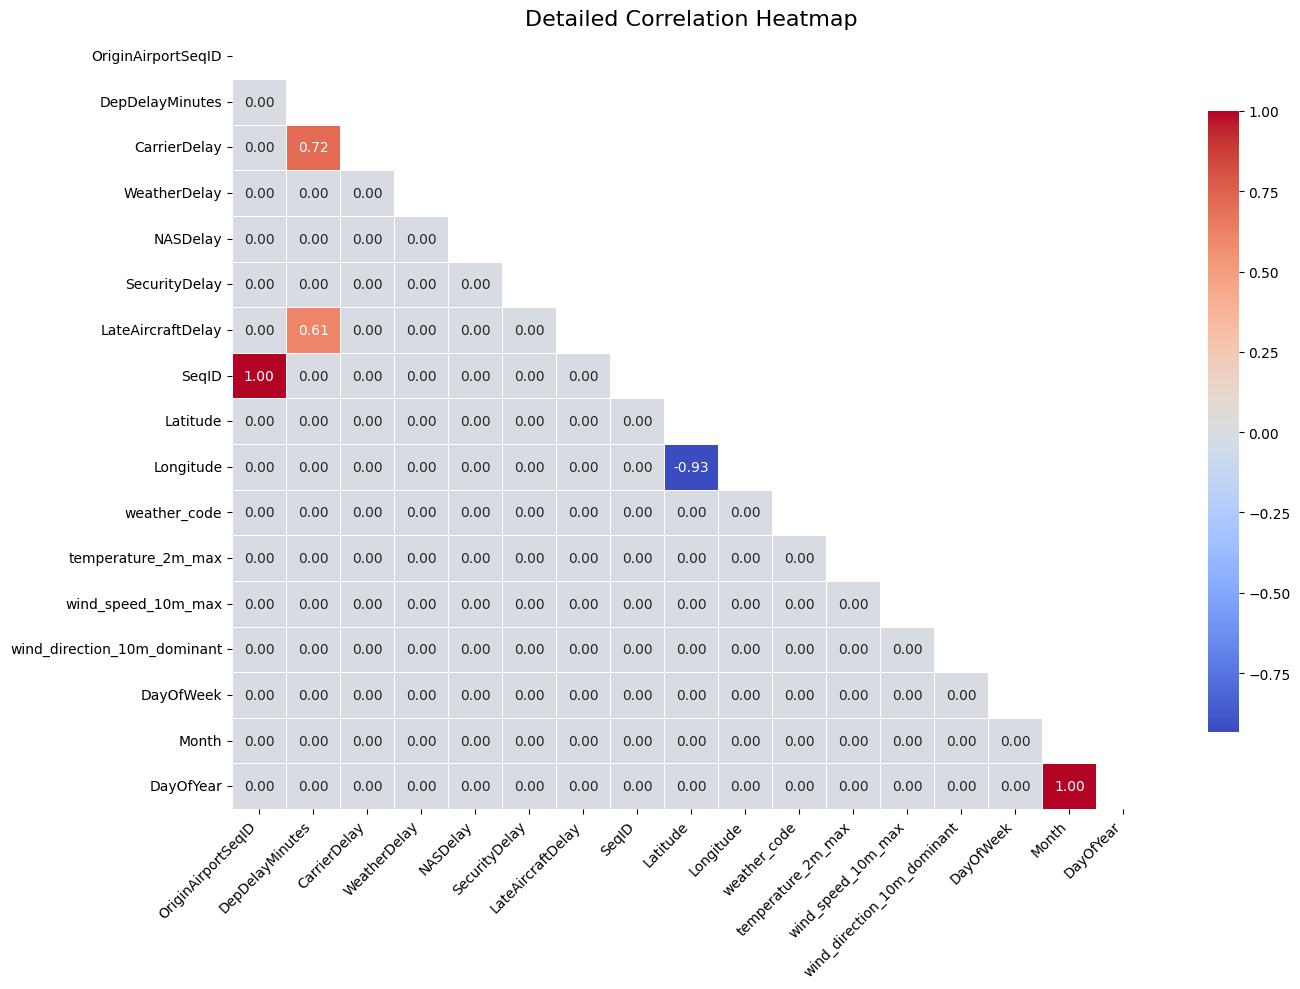

In [6]:
# Step 1: Select Numerical Features
numerical_cols = df.select_dtypes(include=np.number).columns

# Step 2: Sample Rows if Dataset is Large
sampled_df = df[numerical_cols]
if sampled_df.shape[0] > 10000:  # Limit to 10,000 rows
    sampled_df = sampled_df.sample(n=10000, random_state=42)

# Step 3: Compute Correlation Matrix
correlation_matrix = sampled_df.corr()

# Step 4: Focus on Highly Correlated Features
threshold = 0.5  # Only show correlations above or below this threshold
high_corr_features = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
filtered_corr_matrix = high_corr_features.fillna(0)

# Step 5: Create a Mask to Hide the Upper Triangle (Optional)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Step 6: Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    filtered_corr_matrix,
    mask=mask,  # Mask the upper triangle
    cmap='coolwarm',  # Diverging color palette
    annot=True,  # Show correlation values
    fmt=".2f",  # Format for the annotations
    linewidths=0.5,  # Add gridlines between cells
    cbar_kws={"shrink": 0.8},  # Shrink the color bar
)
plt.title("Detailed Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
import plotly.graph_objects as go

# Heatmap for Correlation Matrix
numerical_cols = df.select_dtypes(include=np.number).columns
sampled_df = df[numerical_cols].sample(n=10000, random_state=42)
correlation_matrix = sampled_df.corr()

fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale="Viridis",
        colorbar=dict(title="Correlation"),
    )
)
fig.update_layout(
    title="Interactive Correlation Heatmap",
    xaxis=dict(tickangle=45),
    yaxis=dict(autorange="reversed"),
    width=800,
    height=700,
)
fig.show()

In [8]:
import plotly.express as px

# Check if 'Month' and 'DepDelayMinutes' are available
if 'Month' in df and target_column in df:
    monthly_avg = df.groupby('Month')[target_column].mean().reset_index()
    fig = px.line(
        monthly_avg,
        x='Month',
        y=target_column,
        title='Average Departure Delay by Month',
        labels={'Month': 'Month', target_column: 'Avg Departure Delay (minutes)'},
    )
    fig.update_traces(line=dict(width=3))
    fig.update_layout(xaxis=dict(dtick=1))  # Ensure monthly ticks
    fig.show()
else:
    print("Unable to create time-series plot: required columns not found in the dataset")

In [9]:
# Feature Importance for XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    # Create a DataFrame for Plotly
    feature_data = pd.DataFrame({
        'Feature': [X.columns[i] for i in indices],
        'Importance': importances[indices]
    })

    # Interactive Bar Plot
    fig = px.bar(
        feature_data,
        x='Importance',
        y='Feature',
        orientation='h',
        title='Top 10 Important Features for Delays Prediction',
        labels={'Importance': 'Feature Importance'},
    )
    fig.update_traces(marker_color='blue', opacity=0.7)
    fig.show()
else:
    print("Feature importances are not available in the model.")

In [10]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Replace with your dataset and valid Plotly figures
fig1 = px.scatter(
    df,
    x='WeatherDelay',
    y='DepDelayMinutes',
    title='Weather Delay vs. Departure Delay',
    labels={'WeatherDelay': 'Weather Delay (minutes)', 'DepDelayMinutes': 'Departure Delay (minutes)'}
)

fig2 = px.line(
    df.groupby('Month')['DepDelayMinutes'].mean().reset_index(),
    x='Month',
    y='DepDelayMinutes',
    title='Average Departure Delay by Month',
    labels={'Month': 'Month', 'DepDelayMinutes': 'Avg Departure Delay (minutes)'}
)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Flight Delay Prediction Dashboard"),
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
])

if __name__ == "__main__":
    app.run_server(debug=True)

Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/Users/akshatsharma/CS506/CS506-Final-Project/506env/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
# Step 2: Feature Engineering
# Example: Time-based features (extracting month, day of week, etc.)
if 'FlightDate' in df.columns:
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['DayOfWeek'] = df['FlightDate'].dt.dayofweek
    df['Month'] = df['FlightDate'].dt.month
    df['DayOfYear'] = df['FlightDate'].dt.dayofyear

# Aggregate weather features (e.g., average temperature and delays per day)
if 'Temperature' in df.columns:
    df['AvgDailyTemp'] = df.groupby('DayOfYear')['Temperature'].transform('mean')
else:
    print("Column 'Temperature' is missing. Skipping temperature-based features.")

# Example: Interaction feature between weather and delays
if 'WeatherDelay' in df.columns and 'Temperature' in df.columns:
    df['WeatherDelayImpact'] = df['WeatherDelay'] * df['Temperature']
else:
    print("One or more columns ('WeatherDelay', 'Temperature') are missing. Skipping interaction features.")

# Handle missing values
df.fillna(0, inplace=True)

Column 'Temperature' is missing. Skipping temperature-based features.
One or more columns ('WeatherDelay', 'Temperature') are missing. Skipping interaction features.


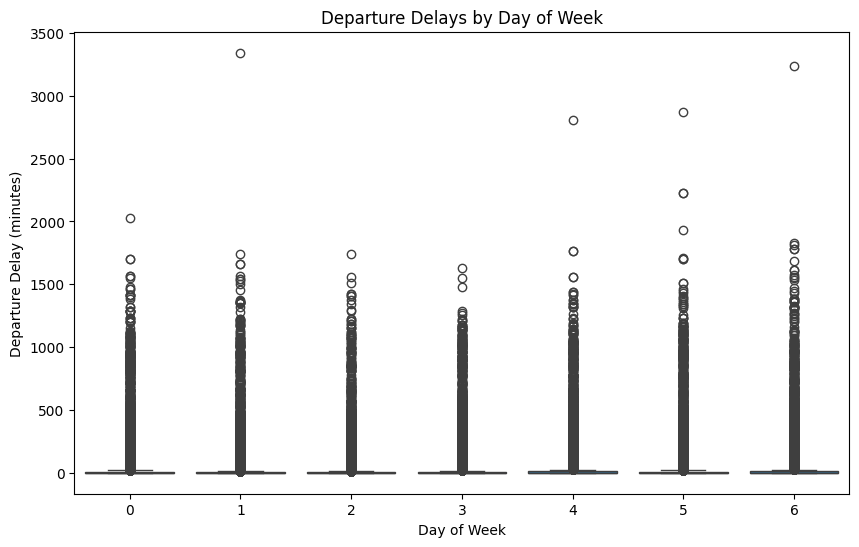

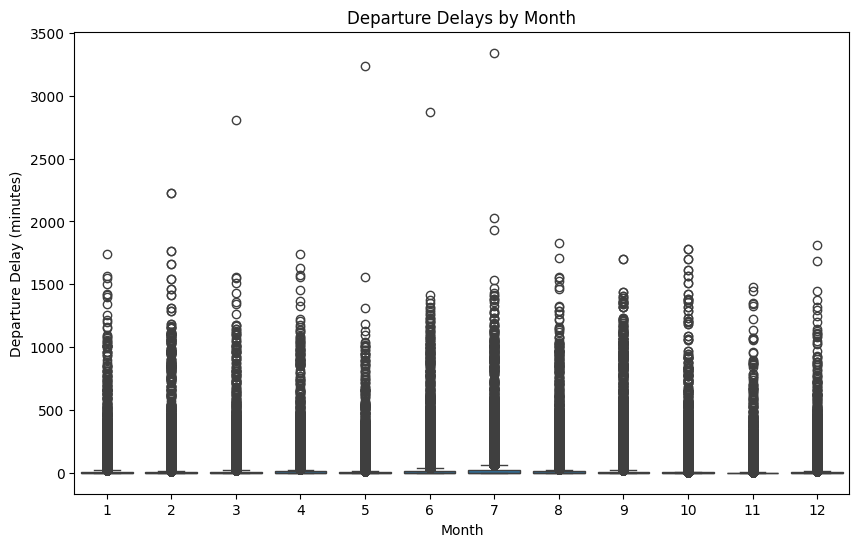

In [ ]:

# Step 3: Capture Patterns in Delays
# Visualize delay patterns across days of the week or months
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='DepDelayMinutes', data=df)
plt.title('Departure Delays by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='DepDelayMinutes', data=df)
plt.title('Departure Delays by Month')
plt.xlabel('Month')
plt.ylabel('Departure Delay (minutes)')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 4: Model Training
# Define features and target variable
columns_to_drop = ['DepDelayMinutes', 'FlightDate', 'Latitude', 'Longitude']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]  # Only drop existing columns

features = df.drop(columns=columns_to_drop, errors='ignore')
X = features.select_dtypes(include=[np.number])  # Use numeric features only
y = df['DepDelayMinutes']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate Models
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))  # Manually calculate RMSE
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))  # Manually calculate RMSE

print(f"Random Forest MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")

Random Forest MAE: 4.38, RMSE: 10.76
XGBoost MAE: 4.89, RMSE: 13.23


In [ ]:
# Step 6: Interactive Dashboard
import dash
from dash import dcc, html
import plotly.express as px

# Create interactive plots using Plotly
fig1 = px.scatter(
    df,
    x='WeatherDelay',
    y='DepDelayMinutes',
    title='Weather Delay vs. Departure Delay',
    labels={'WeatherDelay': 'Weather Delay (minutes)', 'DepDelayMinutes': 'Departure Delay (minutes)'}
)

fig2 = px.line(
    df.groupby('Month')['DepDelayMinutes'].mean().reset_index(),
    x='Month',
    y='DepDelayMinutes',
    title='Average Departure Delay by Month',
    labels={'Month': 'Month', 'DepDelayMinutes': 'Avg Departure Delay (minutes)'}
)

# Set up the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Flight Delay Prediction Dashboard"),
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
])

if __name__ == "__main__":
    app.run_server(debug=True)